### Baseline models
To establish a baseline understanding of model performance, we examine a majority class model, and a simple BERT implementation for multi-class classification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
NOTEBOOK_LOC = "/content/drive/MyDrive/Colab Notebooks/W266 Final Project"

In [3]:
!pip install -q transformers
!pip install pydot --quiet

     |████████████████████████████████| 4.7 MB 9.9 MB/s 
     |████████████████████████████████| 6.6 MB 43.3 MB/s 
     |████████████████████████████████| 101 kB 10.6 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 


In [4]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from transformers import BertTokenizer, TFBertModel

### Load Data

In [ ]:
training_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_training_0.tsv")
training_data.head(5)

,Unnamed: 0,Unnamed: 0.1,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,...,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test,stance,stance_id
0,480,480,2,2,t5,The world will experience a rise in sea level ...,agrees,neutral,neutral,neutral,...,neutral,agrees,neutral,0.003748,0.285125,0.711127,2_2_t5,False,neutral,1
1,481,481,2,2,t6,Global warming will further destabilize alread...,agrees,agrees,agrees,agrees,...,agrees,agrees,agrees,0.000783,0.998215,0.001002,2_2_t6,False,agree,2
2,482,482,2,2,t7,They are on the verge of passing climate legis...,neutral,neutral,neutral,neutral,...,neutral,neutral,neutral,0.000880,0.001103,0.998018,2_2_t7,False,neutral,1
3,484,484,2,2,t9,Global warming has caused and will continue to...,agrees,agrees,agrees,agrees,...,agrees,agrees,agrees,0.000826,0.998171,0.001003,2_2_t9,False,agree,2
4,490,490,2,3,t0,People worry a great deal about global warming.,neutral,neutral,agrees,neutral,...,neutral,neutral,disagrees,0.035291,0.014192,0.950517,2_3_t0,False,neutral,1


In [ ]:
valid_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_val_0.tsv")
valid_data.head(5)

,Unnamed: 0,Unnamed: 0.1,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,...,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test,stance,stance_id
0,11,11,1,0,t14,Flooding has been going on forever.,disagrees,disagrees,disagrees,neutral,...,neutral,disagrees,disagrees,0.710993,0.004516,0.284491,1_0_t14,False,disagree,0
1,12,12,1,0,t15,Simply reducing emissions will not sufficientl...,neutral,agrees,agrees,agrees,...,agrees,agrees,agrees,0.001704,0.973336,0.024960,1_0_t15,False,agree,2
2,13,13,1,0,t16,Climate deniers blame global warming on aliens...,disagrees,agrees,neutral,agrees,...,neutral,agrees,neutral,0.051909,0.387853,0.560239,1_0_t16,False,neutral,1
3,14,14,1,0,t17,"Global warming is inevitably going to be, at b...",disagrees,agrees,agrees,neutral,...,neutral,disagrees,neutral,0.199417,0.477698,0.322885,1_0_t17,False,agree,2
4,15,15,1,0,t18,"Some parts of the world the world, such as the...",neutral,neutral,neutral,neutral,...,neutral,neutral,neutral,0.000800,0.001184,0.998016,1_0_t18,False,neutral,1


In [ ]:
test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_data.head(5)

,Unnamed: 0,Unnamed: 0.1,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,...,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test,stance,stance_id
0,10,10,1,0,t13,Evidence now leans against global warming resu...,disagrees,agrees,disagrees,neutral,...,disagrees,neutral,disagrees,0.535462,0.063947,0.400591,1_0_t13,True,disagree,0
1,19,19,1,0,t21,45 % of the general public view perceived glob...,neutral,neutral,neutral,agrees,...,neutral,neutral,neutral,0.001904,0.036557,0.961540,1_0_t21,True,neutral,1
2,22,22,1,0,t24,There is a danger that we can get used to glob...,agrees,agrees,agrees,agrees,...,agrees,agrees,neutral,0.001625,0.974257,0.024117,1_0_t24,True,agree,2
3,25,25,1,0,t27,Global warming isn’t happening.,disagrees,disagrees,disagrees,disagrees,...,disagrees,disagrees,disagrees,0.997661,0.001168,0.001171,1_0_t27,True,disagree,0
4,31,31,1,0,t6,Humans have a role and therefore as a matter o...,agrees,agrees,agrees,neutral,...,neutral,agrees,agrees,0.002485,0.892785,0.104729,1_0_t6,True,agree,2


### Format Data for Training

In [6]:
TRAIN_TEXTS = []
VALID_TEXTS = []

TRAIN_LABELS = []
VALID_LABELS = []

TRAIN_WEIGHTS = []

TARGET_NAMES = ["disagree", "neutral", "agree"]

CV_IDX = [0, 1, 2, 3, 4]

for cv_idx in CV_IDX:

  training_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_training_"+str(cv_idx)+".tsv")
  valid_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_val_"+str(cv_idx)+".tsv")


  train_texts = training_data["sentence"].to_list()
  train_labels = np.asarray(training_data["stance_id"].astype(int).to_list())

  valid_texts = valid_data["sentence"].to_list()
  valid_labels = np.asarray(valid_data["stance_id"].astype(int).to_list())

  training_data["weight"] = training_data[["agree", "neutral", "disagree"]].max(axis=1)
  train_weights = np.asarray(training_data["weight"]) # add label weights

  TRAIN_TEXTS.append(train_texts)
  VALID_TEXTS.append(valid_texts)

  TRAIN_LABELS.append(train_labels)
  VALID_LABELS.append(valid_labels)

  TRAIN_WEIGHTS.append(train_weights)

test_data = pd.read_table(NOTEBOOK_LOC + "/Data/GWSD_test.tsv")
test_texts = test_data["sentence"].to_list()
test_labels = np.asarray(test_data["stance_id"].astype(int).to_list())

### Majority Class Predictions
Establish initial baseline with majority class predictions

In [13]:
# define model
model = DummyClassifier(strategy='most_frequent')
# fit model
model.fit(train_texts, train_labels)
# make predictions
model.predict(train_texts)
model.score(test_texts, test_labels)

0.425

#### Naive BERT 

In [7]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
max_length = 256

TRAIN_ENCODINGS = []
VALID_ENCODINGS = []
TEST_ENCODINGS = []

for cv_idx in CV_IDX:

  train_encodings = bert_tokenizer(train_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')
  test_encodings = bert_tokenizer(test_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors='tf')

  TRAIN_ENCODINGS.append(train_encodings)
  VALID_ENCODINGS.append(valid_encodings)
  TEST_ENCODINGS.append(test_encodings)

In [9]:
def create_bert_multiclass_model(hidden_size = 100, 
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    A simple BERT classifer using the Pooled Output.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer') 
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}         

    bert_out = bert_model(bert_inputs) 

    pooled_token = bert_out[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(len(TARGET_NAMES), activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                            metrics='accuracy') 

    return classification_model

----------------------Training Cross Fold: 4----------------------
Epoch 1/7
93/93 [==============================] - 84s 684ms/step - loss: 0.1984 - accuracy: 0.9343 - val_loss: 2.1614 - val_accuracy: 0.5312
Epoch 2/7
93/93 [==============================] - 60s 645ms/step - loss: 0.0701 - accuracy: 0.9844 - val_loss: 1.8237 - val_accuracy: 0.5962
Epoch 3/7
93/93 [==============================] - 55s 589ms/step - loss: 0.0690 - accuracy: 0.9804 - val_loss: 2.2380 - val_accuracy: 0.5664
Epoch 4/7
93/93 [==============================] - 60s 643ms/step - loss: 0.0729 - accuracy: 0.9817 - val_loss: 1.8275 - val_accuracy: 0.6043
Epoch 5/7
93/93 [==============================] - 60s 646ms/step - loss: 0.0428 - accuracy: 0.9905 - val_loss: 1.9830 - val_accuracy: 0.6125
Epoch 6/7
93/93 [==============================] - 60s 646ms/step - loss: 0.0311 - accuracy: 0.9932 - val_loss: 2.0350 - val_accuracy: 0.6206
Epoch 7/7
93/93 [==============================] - 54s 584ms/step - loss: 0.0398 

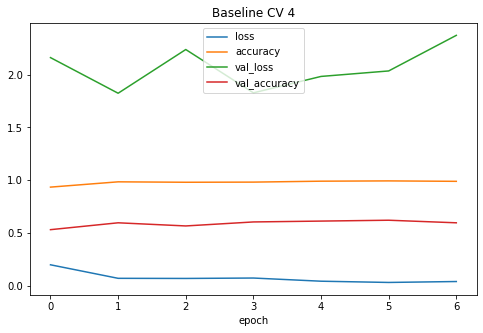

              precision    recall  f1-score   support

    disagree       0.65      0.51      0.57        39
     neutral       0.58      0.84      0.69        85
       agree       0.77      0.47      0.59        76

    accuracy                           0.64       200
   macro avg       0.66      0.61      0.61       200
weighted avg       0.66      0.64      0.63       200



In [42]:
MODEL_NAME = "Baseline"
EPOCHS = 7

for cv_idx in CV_IDX[4:]:
  model = create_bert_multiclass_model(hidden_size=100)

  print("----------------------Training Cross Fold: " + str(cv_idx) + "----------------------")

  checkpoint_filepath = 'Models/' + MODEL_NAME + str(cv_idx)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_freq='epoch',
      save_best_only=True)

  model_history = model.fit([TRAIN_ENCODINGS[cv_idx].input_ids, TRAIN_ENCODINGS[cv_idx].token_type_ids, TRAIN_ENCODINGS[cv_idx].attention_mask], 
                                                  TRAIN_LABELS[cv_idx],   
                                                  validation_data=([VALID_ENCODINGS[cv_idx].input_ids, VALID_ENCODINGS[cv_idx].token_type_ids, VALID_ENCODINGS[cv_idx].attention_mask], 
                                                  VALID_LABELS[cv_idx]),    
                                                  batch_size=16,  
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=EPOCHS)
  
  pd.DataFrame(model_history.history).plot(figsize=(8,5))
  plt.title(MODEL_NAME+' CV ' + str(cv_idx))
  plt.xlabel('epoch')
  plt.savefig(NOTEBOOK_LOC + '/ModelResults/' + MODEL_NAME + str(cv_idx) + ".png")
  plt.show()
  
  model.load_weights(checkpoint_filepath)
  test_predictions = model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask]) 
  print(classification_report(test_labels, np.argmax(test_predictions, axis=1), target_names=TARGET_NAMES))

  np.save(NOTEBOOK_LOC + '/ModelResults/TestPredictions' + MODEL_NAME + str(cv_idx), test_predictions, allow_pickle=True)